In [1]:
import pandas as pd 
import numpy as np 
import os


import matplotlib.pyplot as plt

# we use tensorflow to create our neural network for this experiment 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
train=pd.read_csv("train_data_auth_plus.csv",index_col=0)
train

,text,auth,ad_no_stop,ad_no_stop_freq,text_lemmatized
0,watch webinar to learn why medicare for all wo...,0,watch webinar learn medicare would wrong solut...,watch webinar learn medicare would wrong solut...,watch webinar learn medicare would wrong solut...
1,in this first capsule tony le verger vp financ...,0,first capsule tony le verger vp finance develo...,first capsule tony le verger vp finance develo...,first capsule tony le verger vp finance develo...
2,im so grateful for the leadership shown by dr ...,1,im grateful leadership shown dr anthony fauci ...,im grateful leadership shown dr anthony fauci ...,im grateful leadership shown dr anthony fauci ...
3,with a steady hand and a clear voice lori chav...,1,steady hand clear voice lori chavezderemer tak...,steady hand clear voice lori chavezderemer tak...,steady hand clear voice lori chavezderemer tak...
4,forward tv part \nclick here to stream part s...,0,forward tv part click stream part stay tuned t...,forward tv part click stream part stay tuned t...,forward tv part click stream part stay tuned t...
...,...,...,...,...,...
4066,doug ford stands strong against radical sex ed...,1,doug ford stands strong radical sex ed curricu...,doug ford stands strong radical sex ed curricu...,doug ford stand strong radical sex ed curricul...
4067,teacher groups are cautiously optimistic about...,1,teacher groups cautiously optimistic gov greg ...,teacher groups cautiously optimistic gov greg ...,teacher group cautiously optimistic gov greg a...
4068,republican lawmakers say they cant afford to g...,1,republican lawmakers say cant afford give educ...,republican lawmakers say cant afford give educ...,republican lawmaker say cant afford give educa...
4069,join us for the screening of the award winning...,1,join us screening award winning feature film f...,screening award winning feature film feeling w...,screening award winning feature film feeling w...


In [3]:
test = pd.read_csv("test_data_auth_500.csv",index_col=0)
test

,text,auth,ad_no_stop,ad_no_stop_freq,text_lemmatized
0,looking for more info on a social security dis...,0,looking info social security disability claim ...,looking info social security disability claim ...,looking info social security disability claim ...
1,q what can be done to slow the revolving admin...,1,q done slow revolving administrative turnover ...,q done slow revolving administrative turnover ...,q done slow revolving administrative turnover ...
2,the future of investing is here were like a he...,0,future investing like hedge fund everyone get ...,future investing hedge fund everyone invested,future investing hedge fund everyone invested
3,in october the choice to be made is clear cont...,0,october choice made clear continue road progre...,october choice made clear continue road progre...,october choice made clear continue road progre...
4,grateful for the fabulous science amp health f...,1,grateful fabulous science amp health fundraise...,grateful fabulous science amp health fundraise...,grateful fabulous science amp health fundraise...
...,...,...,...,...,...
565,research shows that too much screen time cause...,1,research shows much screen time causes insomni...,"research shows much screen causes insomnia, ch...","research show much screen cause insomnia, chro..."
566,Evia is developed by experts and backed by sci...,1,Evia developed experts backed science.After co...,Evia developed experts backed science.After co...,Evia developed expert backed science.After con...
567,Stay up-to-date on eBC treatment developments ...,1,Stay up-to-date eBC treatment developments key...,Stay up-to-date eBC treatment developments key...,Stay up-to-date eBC treatment development key ...
568,Give yourself an edge in leadership by learnin...,1,Give edge leadership learning practical change...,Give edge leadership learning practical change...,Give edge leadership learning practical change...


In [4]:
norm_train=train['text_lemmatized']
y_train=train['auth']
norm_test=test['text_lemmatized']
y_test = test['auth']

In [5]:
# data tokenization 
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')

# fit the tokenizer on the training documents
t.fit_on_texts(norm_train)
t.word_index['<PAD>'] = 0
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('facetime', 20302), ('<PAD>', 0), 1)

In [6]:
# create tokenized data sequences to feed to the neural network 
train_sequences = t.texts_to_sequences(norm_train)
test_sequences = t.texts_to_sequences(norm_test)

In [7]:
MAX_SEQUENCE_LENGTH = 1000

# pad documents to equal length with 0 
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((4071, 1000), (570, 1000))

In [8]:
def create_model(units, vocab_size, embedding_dim, maxlen, dropout = 0.2):
  '''
    Create a simple artificial neural network for binary text classification
    Arguments : 
      num_filters: number of filters to use for the 1D convolution layer 
      kernel_size: kernal size used for convolution
      embedding_dim: embedding size 
      maxlen: input sequence length
      vectorize_layer : vectorization layer for turning input text to numerical sequences
      dropout : dropout rate used for Dropout regularization layer to minimize overfitting

    Returns : 
    A model with the folowing layers:  
            - An Embedding layer with embedding_dim dimension for each embedding 
            - A one dimentional global max pooling layer  
            - A fully connected layer with 10 units 
            - The output layer is one neuron with sigmoid activation producing the output label
            - Dropout layers added to minimize overfitting on the small datasets 
  '''
  model = Sequential([
      layers.Input(shape=(maxlen,)),
      layers.Embedding(input_dim = vocab_size , output_dim = embedding_dim, input_length=maxlen),
      layers.Dropout( rate = dropout ),
      layers.GlobalMaxPooling1D(),
      layers.Dropout( rate = dropout),
      layers.Dense(units, activation='relu'),
      layers.Dropout( rate = dropout ),
      layers.Dense(1, activation='sigmoid')              
  ])
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [9]:
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

In [10]:
VOCAB_SIZE = len(t.word_index)

EMBEDDING_DIM = 50
UNITS = 10

# Creating a neural net with randomly set paramteres as a baseline comparison model 
model = create_model(units = UNITS, vocab_size = VOCAB_SIZE, embedding_dim = EMBEDDING_DIM, maxlen = MAX_SEQUENCE_LENGTH )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 50)          1015150   
                                                                 
 dropout (Dropout)           (None, 1000, 50)          0         
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                        

In [11]:
!pip install pyyaml h5py

%cd '/content/gdrive/Shared drives/PFE/Colab Notebooks/Task 2/authority/data'

[WinError 3] Le chemin d’accès spécifié est introuvable: "'/content/gdrive/Shared drives/PFE/Colab Notebooks/Task 2/authority/data'"
C:\Users\amieurn\Desktop\auth_validation


Epoch 1/5
115/115 [==============================] - 3s 23ms/step - loss: 0.6630 - accuracy: 0.6598 - val_loss: 0.6080 - val_accuracy: 0.9265
Epoch 2/5
115/115 [==============================] - 3s 22ms/step - loss: 0.4421 - accuracy: 0.9307 - val_loss: 0.2936 - val_accuracy: 0.9583
Epoch 3/5
115/115 [==============================] - 3s 22ms/step - loss: 0.1687 - accuracy: 0.9760 - val_loss: 0.1344 - val_accuracy: 0.9632
Epoch 4/5
115/115 [==============================] - 3s 22ms/step - loss: 0.0749 - accuracy: 0.9869 - val_loss: 0.0911 - val_accuracy: 0.9681
Epoch 5/5
115/115 [==============================] - 3s 22ms/step - loss: 0.0420 - accuracy: 0.9932 - val_loss: 0.0732 - val_accuracy: 0.9755


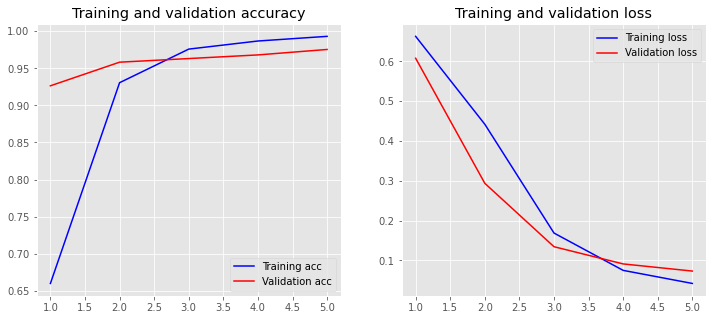

In [12]:
# Train the neural net and evaluate results 
history = model.fit(X_train, y_train, epochs= 5, batch_size= 32,  shuffle=True, validation_split=0.1, verbose=1)
plot_history(history)

In [13]:
# model evaluation 
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

18/18 [==============================] - 0s 3ms/step - loss: 0.5457 - accuracy: 0.8719
Accuracy: 87.19%


In [15]:
# get model predictions 
prediction_probs = model.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
predictions[:10]

18/18 [==============================] - 0s 2ms/step


[0, 1, 0, 0, 1, 0, 1, 1, 0, 0]

In [16]:
!pip install scikit-plot
import scikitplot as skplt

              precision    recall  f1-score   support

   authority       0.98      0.83      0.90       389
no-authority       0.72      0.97      0.83       181

    accuracy                           0.87       570
   macro avg       0.85      0.90      0.86       570
weighted avg       0.90      0.87      0.88       570

confusion matrix:
[[322  67]
 [  6 175]]



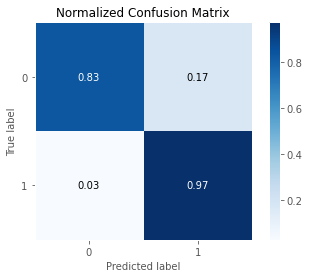

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

print(metrics.classification_report(y_test, predictions, target_names=['authority', 'no-authority']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()

skplt.metrics.plot_confusion_matrix(y_test, predictions , normalize=True)
plt.show()

In [18]:
df_val = pd.read_csv('sample_val_preprocessed_final_170.csv',index_col=0)
df_val

,ad,authority,ad_no_stop,ad_no_stop_freq,text_lemmatized
60,the majority of parents want their children to...,0,majority parents want children love however ma...,majority parents want children love however ma...,majority parent want child love however many y...
46,profitez des aides et des nouveaux barèmes dep...,0,profitez des aides et des nouveaux barèmes dep...,profitez des aides et des nouveaux barèmes dep...,profitez de aide et de nouveaux barèmes depuis...
41,the only way to change the government and get ...,0,way change government get real action climate ...,way change government real action climate chan...,way change government real action climate chan...
117,bringing hope and restoration to a community i...,0,bringing hope restoration community dire despe...,bringing hope restoration community dire despe...,bringing hope restoration community dire despe...
143,retired judges call for a national anticorrup...,1,retired judges call national anticorruption co...,retired judges call national anticorruption co...,retired judge call national anticorruption com...
...,...,...,...,...,...
140,today alexei navalny was awarded the sakharov...,0,today alexei navalny awarded sakharov prize fr...,alexei navalny awarded sakharov prize freedom ...,alexei navalny awarded sakharov prize freedom ...
75,the morrison govt is climate record shows they...,0,morrison govt climate record shows plan replac...,morrison govt climate record shows plan replac...,morrison govt climate record show plan replace...
109,as a member of congress dr ruiz has built a re...,1,member congress dr ruiz built reputation bipar...,member congress dr ruiz built reputation bipar...,member congress dr ruiz built reputation bipar...
111,thank you to the republican party network for ...,0,thank republican party network recent meeting ...,thank republican party network recent meeting ...,thank republican party network recent meeting ...


accuracy:   0.741
              precision    recall  f1-score   support

     no-auth       0.94      0.65      0.77       113
        auth       0.57      0.91      0.70        57

    accuracy                           0.74       170
   macro avg       0.75      0.78      0.74       170
weighted avg       0.81      0.74      0.75       170

confusion matrix:
[[74 39]
 [ 5 52]]



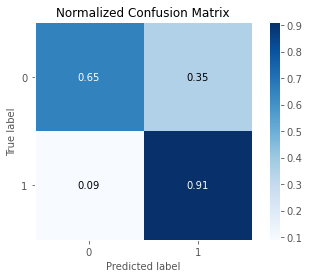

In [19]:
val_sequences = t.texts_to_sequences(df_val['text_lemmatized'])
X_val = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
y_val = df_val['authority']

prediction_probs = model.predict(X_val).ravel()
y_pred  = [1 if prob > 0.5 else 0 for prob in prediction_probs]


score = metrics.accuracy_score(y_val, y_pred)
print("accuracy:   %0.3f" % score)

print(metrics.classification_report(y_val, y_pred, target_names=[ 'no-auth', 'auth']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_val, y_pred))
print()

skplt.metrics.plot_confusion_matrix(y_val, y_pred, normalize=True)
plt.show()
